# Import Modules

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from time import time
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchmetrics import Accuracy

# Dataset

In [2]:
batch_size = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=crop_size, scale=(0.8, 1.0)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(size=crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("../datasets/hidrangea/train/", transform=train_transform)
train_dataloader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)

test_set = datasets.ImageFolder("../datasets/hidrangea/test/", transform=test_transform)
test_dataloader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

# Build Model

## Architecture

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=1024, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(256, 2),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x
    
model = Model()
model

Model(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )

## Loss Function

In [4]:
nll_loss = nn.NLLLoss()
nll_loss

NLLLoss()

## Evaluation Metric

In [5]:
accuracy = Accuracy()
accuracy

Accuracy()

## Optimizer

In [6]:
adamw_optimizer = optim.AdamW(model.parameters(), lr=0.001)
adamw_optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)

## Loop Function

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer, eval_metric):
    print("Train:")
    
    losses = []
    for batch, (feature, label) in enumerate(dataloader, 1):
        # Forwardpropagation
        pred_label = model(feature)
        loss = loss_fn(pred_label, label)
        acc = eval_metric(pred_label, label)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        losses.append(loss)
        
        print(f"Batch-{batch} | Accuracy: {acc:>7f} | Loss: {loss:>7f}")
        
    acc = eval_metric.compute()
    loss = sum(losses) / len(dataloader)
    print(f"Accuracy : {acc}")
    print(f"Loss     : {loss}")
    eval_metric.reset()
    
    return acc, loss
    
def test_loop(dataloader, model, loss_fn, eval_metric):
    print("\nTest:")
    
    losses = []
    for batch, (feature, label) in enumerate(dataloader, 1):
        # Forwardpropagation
        pred_label = model(feature)
        loss = loss_fn(pred_label, label)
        acc = eval_metric(pred_label, label)
        
        with torch.no_grad():
            loss = loss.item()
            losses.append(loss)
        
        print(f"Batch-{batch} | Accuracy: {acc:>7f} | Loss: {loss:>7f}")
        
    acc = eval_metric.compute()
    loss = sum(losses) / len(dataloader)
    print(f"Accuracy : {acc}")
    print(f"Loss     : {loss}")
    eval_metric.reset()
    
    return acc, loss

In [8]:
epochs = 20
train_accuracies, train_losses = [], []
test_accuracies, test_losses = [], []

start = time()
for epoch in range(epochs):
    print(f"EPOCH {epoch + 1}")
    print("=" * 46, end="\n")
    acc_train, loss_train = train_loop(train_dataloader, model, nll_loss, adamw_optimizer, accuracy)
    acc_test, loss_test = test_loop(test_dataloader, model, nll_loss, accuracy)
    print("=" * 46, end="\n\n")
    
    train_accuracies.append(acc_train)
    train_losses.append(loss_train)
    test_accuracies.append(acc_test)
    test_losses.append(loss_test)
    
torch.save(model.state_dict(), "../pretrained_model/hidrangea.pth")
stop = time()

total_time = stop - start
print(f"Training time: {(total_time / 60):.3f} minutes")

EPOCH 1
Train:
Batch-1 | Accuracy: 0.453125 | Loss: 0.695688
Batch-2 | Accuracy: 0.554688 | Loss: 0.686020
Batch-3 | Accuracy: 0.460938 | Loss: 0.715263
Batch-4 | Accuracy: 0.492188 | Loss: 0.697719
Batch-5 | Accuracy: 0.421875 | Loss: 0.701221
Batch-6 | Accuracy: 0.492188 | Loss: 0.690861
Batch-7 | Accuracy: 0.593750 | Loss: 0.691268
Batch-8 | Accuracy: 0.403846 | Loss: 0.697475
Accuracy : 0.4860000014305115
Loss     : 0.6969395652413368

Test:
Batch-1 | Accuracy: 0.492188 | Loss: 0.691913
Batch-2 | Accuracy: 0.507812 | Loss: 0.691913
Batch-3 | Accuracy: 0.500000 | Loss: 0.692148
Batch-4 | Accuracy: 0.500000 | Loss: 0.692179
Accuracy : 0.5
Loss     : 0.6920383721590042

EPOCH 2
Train:
Batch-1 | Accuracy: 0.476562 | Loss: 0.693166
Batch-2 | Accuracy: 0.492188 | Loss: 0.692771
Batch-3 | Accuracy: 0.492188 | Loss: 0.691745
Batch-4 | Accuracy: 0.429688 | Loss: 0.695710
Batch-5 | Accuracy: 0.507812 | Loss: 0.690923
Batch-6 | Accuracy: 0.539062 | Loss: 0.688528
Batch-7 | Accuracy: 0.562500 

Batch-7 | Accuracy: 0.859375 | Loss: 0.376161
Batch-8 | Accuracy: 0.836538 | Loss: 0.344051
Accuracy : 0.8299999833106995
Loss     : 0.39095398038625717

Test:
Batch-1 | Accuracy: 0.851562 | Loss: 0.373602
Batch-2 | Accuracy: 0.843750 | Loss: 0.395426
Batch-3 | Accuracy: 0.843750 | Loss: 0.343033
Batch-4 | Accuracy: 0.812500 | Loss: 0.348775
Accuracy : 0.8450000286102295
Loss     : 0.3652089014649391

EPOCH 12
Train:
Batch-1 | Accuracy: 0.828125 | Loss: 0.392189
Batch-2 | Accuracy: 0.812500 | Loss: 0.388864
Batch-3 | Accuracy: 0.843750 | Loss: 0.331236
Batch-4 | Accuracy: 0.835938 | Loss: 0.391314
Batch-5 | Accuracy: 0.851562 | Loss: 0.337795
Batch-6 | Accuracy: 0.859375 | Loss: 0.335014
Batch-7 | Accuracy: 0.812500 | Loss: 0.468499
Batch-8 | Accuracy: 0.865385 | Loss: 0.385281
Accuracy : 0.8379999995231628
Loss     : 0.378774031996727

Test:
Batch-1 | Accuracy: 0.867188 | Loss: 0.320441
Batch-2 | Accuracy: 0.843750 | Loss: 0.357516
Batch-3 | Accuracy: 0.835938 | Loss: 0.367460
Batch-4

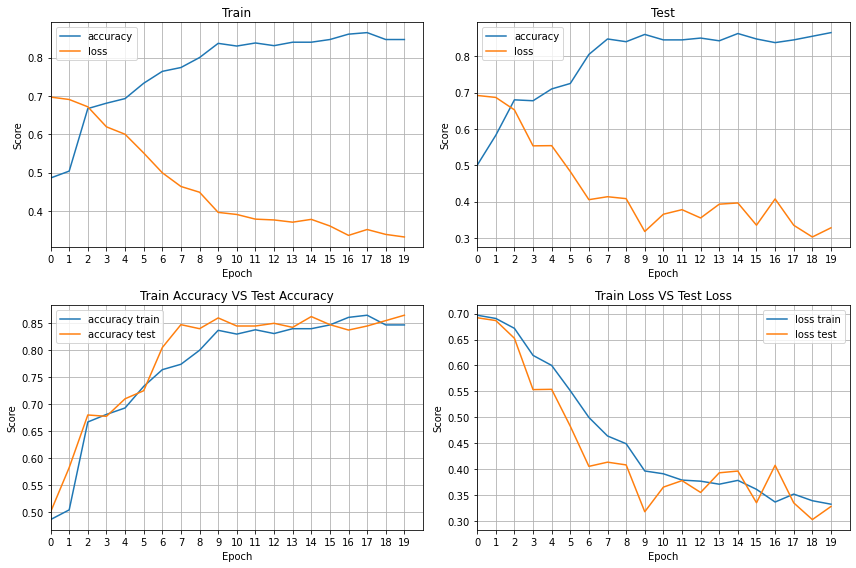

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(12, 8))

ax[0][0].set_title("Train")
ax[0][0].plot(train_accuracies, label="accuracy")
ax[0][0].plot(train_losses, label="loss")
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Score")
ax[0][0].set_xticks(list(range(0, 20)))
ax[0][0].set_xlim(0, 20)
ax[0][0].legend()
ax[0][0].grid();

ax[0][1].set_title("Test")
ax[0][1].plot(test_accuracies, label="accuracy")
ax[0][1].plot(test_losses, label="loss")
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Score")
ax[0][1].set_xticks(list(range(0, 20)))
ax[0][1].set_xlim(0, 20)
ax[0][1].legend()
ax[0][1].grid();

ax[1][0].set_title("Train Accuracy VS Test Accuracy")
ax[1][0].plot(train_accuracies, label="accuracy train")
ax[1][0].plot(test_accuracies, label="accuracy test")
ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Score")
ax[1][0].set_xticks(list(range(0, 20)))
ax[1][0].set_xlim(0, 20)
ax[1][0].legend()
ax[1][0].grid();

ax[1][1].set_title("Train Loss VS Test Loss")
ax[1][1].plot(train_losses, label="loss train")
ax[1][1].plot(test_losses, label="loss test")
ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Score")
ax[1][1].set_xticks(list(range(0, 20)))
ax[1][1].set_xlim(0, 20)
ax[1][1].legend()
ax[1][1].grid();

# Prediction

In [10]:
features, labels = next(iter(test_dataloader))

with torch.no_grad():
    model.eval()
    output = model(features)
    preds = output.argmax(dim=1)
    
preds

tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1])

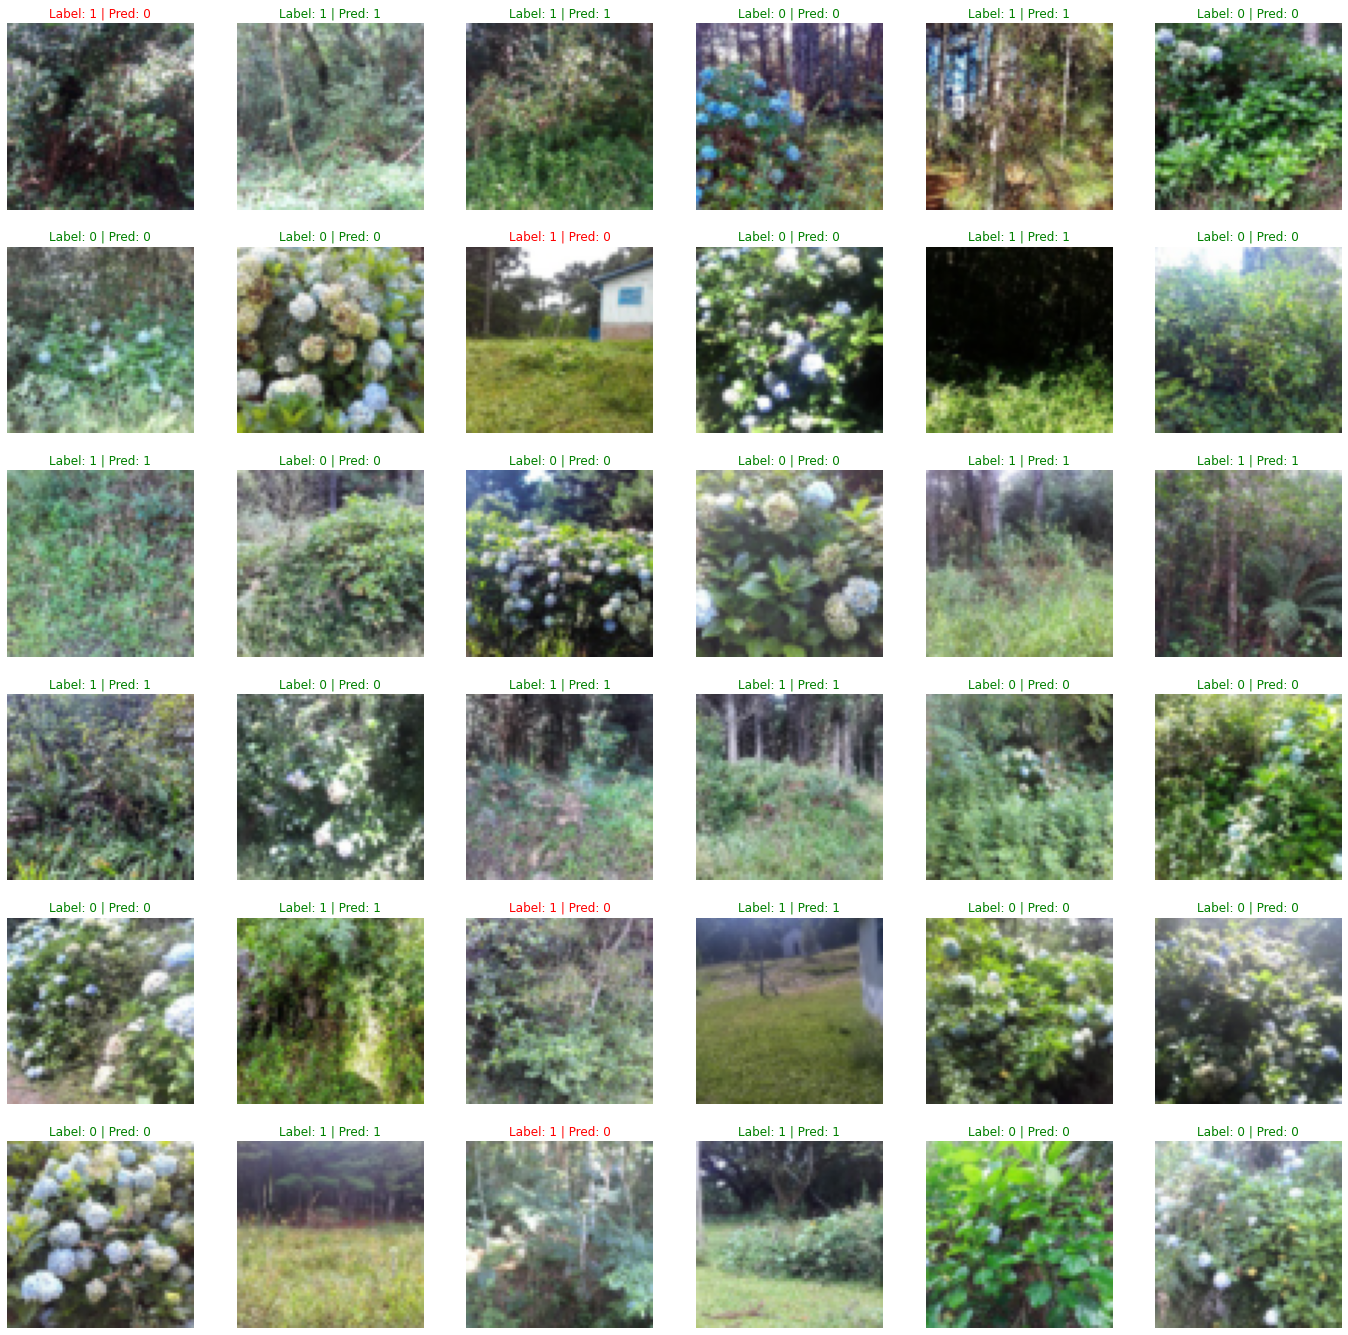

In [18]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))

for image, label, pred, ax in zip(features, labels, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": "red"} if label != pred else {"color": "green"}
    ax.set_title(f"Label: {label} | Pred: {pred}",
                 fontdict=font)
    ax.axis("off")